In [33]:
# https://www.infiniteloop.co.jp/blog/2018/02/learning-keras-06/
# https://www.ag.kagawa-u.ac.jp/charlesy/2017/07/21/keras%E3%81%A7%E5%8C%96%E5%90%88%E7%89%A9%E3%81%AE%E6%BA%B6%E8%A7%A3%E5%BA%A6%E4%BA%88%E6%B8%AC%EF%BC%88%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC/

In [34]:
import sys
sys.path.append('/home/yoshida/.pyenv/versions/3.6.6/lib/python3.6/site-packages')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from keras.datasets import imdb
# from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
# from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Dense, Activation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from keras.optimizers import SGD

In [35]:
# データの読み込み

data = pd.read_csv("../src/Aiko_normalization_ver3_aaa.csv")
df = pd.DataFrame(data)

In [36]:
df.drop(['No','width','height','seed_date','house','url', 'COL_21'], axis=1, inplace=True) #対象の列を削除

In [37]:
# AveDiffTemp_7、AveSatu_7、monthを対象としたい時
df.drop(['AveMinTemp_7', 'AveSatu_7', 'AveDiffTemp_7', 'AveMaxTemp_7','SumMaxTemp_7','SumMinTemp_7','SumDiffTemp_7'], axis=1, inplace=True)

In [38]:
df['month'] = df['current_date'].str[:2] # "11月28日"とか"4月3日"の月日の先頭2文字だけ抽出
df['month'] = df['month'].str.strip('月') # このままだと"4月"のように"月"が入っているので、"月"を削除する
# 参考：https://deepage.net/features/pandas-str-extract.html
# 参考：https://deepage.net/features/pandas-str-replace.html
df['month'].isnull().sum() # 欠損値がないかを確認

df.drop(['current_date'], axis=1, inplace=True) # current_dateはもう使わない
print(df.shape)

(2176, 7)


In [39]:
# 四半期を求める(4~6月:1st、7~9月:2nd、10~12月:3rd、1~3月:4th)(＊＊＊＊使うか使わないか＊＊＊＊)
df['quarter'] = df['month'].replace({'4': '1st', '5': '1st', '6': '1st', 
                                     '7': '2nd', '8': '2nd', '9': '2nd', 
                                     '10': '3rd', '11': '3rd', '12': '3rd', 
                                     '1': '4th', '2': '4th', '3': '4th'
                                    })

In [40]:
# ダミー変数の作成
df = pd.get_dummies(df, columns=['quarter'], drop_first=True)

In [41]:
y = df["sweet_category"] #目的変数
df.drop(['sweet','sweet_category'], axis=1, inplace=True) #目的変数の列を削除
print(df.shape)

(2176, 7)


In [42]:
df.drop(['month'], axis=1, inplace=True)

In [43]:
df.head(3)

,size,AveCO2_7,AveHum_7,AveTemp_7,quarter_3rd,quarter_4th
0,7.54,614.28,66.84,21.14,1,0
1,6.48,614.28,66.84,21.14,1,0
2,8.68,614.28,66.84,21.14,1,0


In [44]:
from sklearn import preprocessing
df = preprocessing.scale(df)

/home/yoshida/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


In [45]:
df

array([[ 0.53104481,  0.79303369,  1.11169128, -0.46033908,  2.97424845,
        -0.83904335],
       [-0.04823753,  0.79303369,  1.11169128, -0.46033908,  2.97424845,
        -0.83904335],
       [ 1.15404658,  0.79303369,  1.11169128, -0.46033908,  2.97424845,
        -0.83904335],
       ...,
       [-0.34334363, -1.33108582,  1.03852164,  0.20059694, -0.33621939,
        -0.83904335],
       [ 0.18128944, -1.33108582,  1.03852164,  0.20059694, -0.33621939,
        -0.83904335],
       [ 1.27973992, -1.33108582,  1.03852164,  0.20059694, -0.33621939,
        -0.83904335]])

In [46]:
y

0       2
1       2
2       1
3       1
4       2
5       2
6       2
7       2
8       2
9       2
10      2
11      2
12      3
13      2
14      3
15      3
16      3
17      3
18      3
19      3
20      3
21      3
22      2
23      2
24      2
25      3
26      3
27      4
28      4
29      4
       ..
2146    3
2147    2
2148    2
2149    1
2150    2
2151    3
2152    4
2153    2
2154    2
2155    3
2156    2
2157    1
2158    4
2159    2
2160    3
2161    4
2162    2
2163    3
2164    1
2165    3
2166    3
2167    2
2168    3
2169    3
2170    2
2171    2
2172    3
2173    4
2174    3
2175    2
Name: sweet_category, Length: 2176, dtype: int64

In [47]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)  # one-hotエンコード.例) 1 => [0, 1, 0]

In [48]:
y[27]

array([0., 0., 0., 0., 1.], dtype=float32)

In [49]:
y[:,0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [50]:
# 開発セットとテストセットに分割
X_trainval, X_test, y_trainval, y_test = train_test_split(df, y, test_size=0.3, random_state=0)
#stratify は母集団のカテゴリの割合を保って分割するもので、目的変数を指定するのが一般的

In [51]:
# 訓練セットとテストセットに分割
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.3, stratify=y_trainval, random_state=0)

In [52]:
# 入力データ数＝入力層の数
num_input = X_test.shape[1]

# 分類するクラスの数
num_classes = y_test.shape[1]

In [53]:
model = Sequential()
model.add(Dense(10, activation="relu", input_dim=num_input)) #out_dim:10
model.add(Dense(7, activation="relu")) #out_dim:8
model.add(layers.Dense(num_classes, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy']) #'binaryではなくて'、categorical_crossentropyも気になる

In [54]:
# validation_dataに検証変数を入れることで、訓練データと検証データの学習サイクルが見える
result = model.fit(X_train, y_train, epochs=600, batch_size=512, validation_data = (X_val, y_val))

Train on 1066 samples, validate on 457 samples
Epoch 1/600
1066/1066 [==============================] - 0s 426us/step - loss: 1.5639 - acc: 0.2608 - val_loss: 1.5968 - val_acc: 0.2319
Epoch 2/600
1066/1066 [==============================] - 0s 14us/step - loss: 1.5500 - acc: 0.2627 - val_loss: 1.5833 - val_acc: 0.2363
Epoch 3/600
1066/1066 [==============================] - 0s 16us/step - loss: 1.5367 - acc: 0.2730 - val_loss: 1.5700 - val_acc: 0.2473
Epoch 4/600
1066/1066 [==============================] - 0s 14us/step - loss: 1.5237 - acc: 0.2795 - val_loss: 1.5568 - val_acc: 0.2538
Epoch 5/600
1066/1066 [==============================] - 0s 22us/step - loss: 1.5108 - acc: 0.2833 - val_loss: 1.5439 - val_acc: 0.2713
Epoch 6/600
1066/1066 [==============================] - 0s 18us/step - loss: 1.4985 - acc: 0.2964 - val_loss: 1.5315 - val_acc: 0.2735
Epoch 7/600
1066/1066 [==============================] - 0s 10us/step - loss: 1.4863 - acc: 0.3058 - val_loss: 1.5197 - val_acc: 0.2735


1066/1066 [==============================] - 0s 24us/step - loss: 1.0758 - acc: 0.5750 - val_loss: 1.1130 - val_acc: 0.5755
Epoch 61/600
1066/1066 [==============================] - 0s 17us/step - loss: 1.0696 - acc: 0.5769 - val_loss: 1.1068 - val_acc: 0.5733
Epoch 62/600
1066/1066 [==============================] - 0s 16us/step - loss: 1.0636 - acc: 0.5788 - val_loss: 1.1006 - val_acc: 0.5799
Epoch 63/600
1066/1066 [==============================] - 0s 16us/step - loss: 1.0576 - acc: 0.5835 - val_loss: 1.0945 - val_acc: 0.5864
Epoch 64/600
1066/1066 [==============================] - 0s 12us/step - loss: 1.0518 - acc: 0.5882 - val_loss: 1.0885 - val_acc: 0.5864
Epoch 65/600
1066/1066 [==============================] - 0s 15us/step - loss: 1.0460 - acc: 0.5863 - val_loss: 1.0825 - val_acc: 0.5864
Epoch 66/600
1066/1066 [==============================] - 0s 17us/step - loss: 1.0403 - acc: 0.5891 - val_loss: 1.0766 - val_acc: 0.5974
Epoch 67/600
1066/1066 [==============================

Epoch 120/600
1066/1066 [==============================] - 0s 18us/step - loss: 0.7746 - acc: 0.6792 - val_loss: 0.7918 - val_acc: 0.6849
Epoch 121/600
1066/1066 [==============================] - 0s 13us/step - loss: 0.7712 - acc: 0.6792 - val_loss: 0.7881 - val_acc: 0.6849
Epoch 122/600
1066/1066 [==============================] - 0s 19us/step - loss: 0.7678 - acc: 0.6792 - val_loss: 0.7844 - val_acc: 0.6893
Epoch 123/600
1066/1066 [==============================] - 0s 17us/step - loss: 0.7642 - acc: 0.6829 - val_loss: 0.7809 - val_acc: 0.6893
Epoch 124/600
1066/1066 [==============================] - 0s 16us/step - loss: 0.7608 - acc: 0.6829 - val_loss: 0.7778 - val_acc: 0.6980
Epoch 125/600
1066/1066 [==============================] - 0s 15us/step - loss: 0.7575 - acc: 0.6848 - val_loss: 0.7749 - val_acc: 0.7046
Epoch 126/600
1066/1066 [==============================] - 0s 17us/step - loss: 0.7544 - acc: 0.6904 - val_loss: 0.7723 - val_acc: 0.7090
Epoch 127/600
1066/1066 [=========

1066/1066 [==============================] - 0s 12us/step - loss: 0.6522 - acc: 0.7251 - val_loss: 0.6700 - val_acc: 0.7309
Epoch 180/600
1066/1066 [==============================] - 0s 15us/step - loss: 0.6511 - acc: 0.7214 - val_loss: 0.6693 - val_acc: 0.7265
Epoch 181/600
1066/1066 [==============================] - 0s 19us/step - loss: 0.6501 - acc: 0.7214 - val_loss: 0.6688 - val_acc: 0.7309
Epoch 182/600
1066/1066 [==============================] - 0s 27us/step - loss: 0.6493 - acc: 0.7214 - val_loss: 0.6685 - val_acc: 0.7330
Epoch 183/600
1066/1066 [==============================] - 0s 24us/step - loss: 0.6485 - acc: 0.7233 - val_loss: 0.6679 - val_acc: 0.7330
Epoch 184/600
1066/1066 [==============================] - 0s 22us/step - loss: 0.6477 - acc: 0.7242 - val_loss: 0.6671 - val_acc: 0.7330
Epoch 185/600
1066/1066 [==============================] - 0s 22us/step - loss: 0.6464 - acc: 0.7195 - val_loss: 0.6659 - val_acc: 0.7352
Epoch 186/600
1066/1066 [=======================

1066/1066 [==============================] - 0s 15us/step - loss: 0.6074 - acc: 0.7233 - val_loss: 0.6325 - val_acc: 0.7199
Epoch 239/600
1066/1066 [==============================] - 0s 22us/step - loss: 0.6069 - acc: 0.7251 - val_loss: 0.6316 - val_acc: 0.7199
Epoch 240/600
1066/1066 [==============================] - 0s 16us/step - loss: 0.6066 - acc: 0.7214 - val_loss: 0.6307 - val_acc: 0.7221
Epoch 241/600
1066/1066 [==============================] - 0s 11us/step - loss: 0.6064 - acc: 0.7205 - val_loss: 0.6301 - val_acc: 0.7199
Epoch 242/600
1066/1066 [==============================] - 0s 12us/step - loss: 0.6061 - acc: 0.7214 - val_loss: 0.6294 - val_acc: 0.7221
Epoch 243/600
1066/1066 [==============================] - 0s 22us/step - loss: 0.6058 - acc: 0.7270 - val_loss: 0.6288 - val_acc: 0.7221
Epoch 244/600
1066/1066 [==============================] - 0s 16us/step - loss: 0.6052 - acc: 0.7233 - val_loss: 0.6285 - val_acc: 0.7199
Epoch 245/600
1066/1066 [=======================

1066/1066 [==============================] - 0s 15us/step - loss: 0.5883 - acc: 0.7458 - val_loss: 0.6237 - val_acc: 0.7265
Epoch 298/600
1066/1066 [==============================] - 0s 16us/step - loss: 0.5880 - acc: 0.7458 - val_loss: 0.6239 - val_acc: 0.7265
Epoch 299/600
1066/1066 [==============================] - 0s 17us/step - loss: 0.5880 - acc: 0.7458 - val_loss: 0.6234 - val_acc: 0.7265
Epoch 300/600
1066/1066 [==============================] - 0s 16us/step - loss: 0.5876 - acc: 0.7467 - val_loss: 0.6227 - val_acc: 0.7265
Epoch 301/600
1066/1066 [==============================] - 0s 12us/step - loss: 0.5873 - acc: 0.7505 - val_loss: 0.6219 - val_acc: 0.7243
Epoch 302/600
1066/1066 [==============================] - 0s 15us/step - loss: 0.5870 - acc: 0.7505 - val_loss: 0.6213 - val_acc: 0.7265
Epoch 303/600
1066/1066 [==============================] - 0s 15us/step - loss: 0.5870 - acc: 0.7477 - val_loss: 0.6213 - val_acc: 0.7265
Epoch 304/600
1066/1066 [=======================

1066/1066 [==============================] - 0s 16us/step - loss: 0.5783 - acc: 0.7552 - val_loss: 0.6124 - val_acc: 0.7221
Epoch 357/600
1066/1066 [==============================] - 0s 16us/step - loss: 0.5783 - acc: 0.7486 - val_loss: 0.6122 - val_acc: 0.7265
Epoch 358/600
1066/1066 [==============================] - 0s 11us/step - loss: 0.5779 - acc: 0.7505 - val_loss: 0.6113 - val_acc: 0.7309
Epoch 359/600
1066/1066 [==============================] - 0s 17us/step - loss: 0.5775 - acc: 0.7505 - val_loss: 0.6101 - val_acc: 0.7287
Epoch 360/600
1066/1066 [==============================] - 0s 15us/step - loss: 0.5770 - acc: 0.7523 - val_loss: 0.6089 - val_acc: 0.7287
Epoch 361/600
1066/1066 [==============================] - 0s 20us/step - loss: 0.5770 - acc: 0.7523 - val_loss: 0.6085 - val_acc: 0.7287
Epoch 362/600
1066/1066 [==============================] - 0s 18us/step - loss: 0.5768 - acc: 0.7523 - val_loss: 0.6090 - val_acc: 0.7243
Epoch 363/600
1066/1066 [=======================

1066/1066 [==============================] - 0s 12us/step - loss: 0.5693 - acc: 0.7552 - val_loss: 0.6024 - val_acc: 0.7265
Epoch 416/600
1066/1066 [==============================] - 0s 14us/step - loss: 0.5692 - acc: 0.7533 - val_loss: 0.6022 - val_acc: 0.7265
Epoch 417/600
1066/1066 [==============================] - 0s 26us/step - loss: 0.5690 - acc: 0.7505 - val_loss: 0.6018 - val_acc: 0.7243
Epoch 418/600
1066/1066 [==============================] - 0s 14us/step - loss: 0.5689 - acc: 0.7477 - val_loss: 0.6012 - val_acc: 0.7243
Epoch 419/600
1066/1066 [==============================] - 0s 18us/step - loss: 0.5690 - acc: 0.7467 - val_loss: 0.6014 - val_acc: 0.7243
Epoch 420/600
1066/1066 [==============================] - 0s 22us/step - loss: 0.5689 - acc: 0.7486 - val_loss: 0.6023 - val_acc: 0.7287
Epoch 421/600
1066/1066 [==============================] - 0s 13us/step - loss: 0.5686 - acc: 0.7495 - val_loss: 0.6030 - val_acc: 0.7287
Epoch 422/600
1066/1066 [=======================

1066/1066 [==============================] - 0s 14us/step - loss: 0.5625 - acc: 0.7523 - val_loss: 0.6000 - val_acc: 0.7243
Epoch 475/600
1066/1066 [==============================] - 0s 12us/step - loss: 0.5622 - acc: 0.7552 - val_loss: 0.6002 - val_acc: 0.7243
Epoch 476/600
1066/1066 [==============================] - 0s 17us/step - loss: 0.5619 - acc: 0.7570 - val_loss: 0.6003 - val_acc: 0.7243
Epoch 477/600
1066/1066 [==============================] - 0s 16us/step - loss: 0.5618 - acc: 0.7598 - val_loss: 0.6002 - val_acc: 0.7287
Epoch 478/600
1066/1066 [==============================] - 0s 13us/step - loss: 0.5615 - acc: 0.7570 - val_loss: 0.5995 - val_acc: 0.7309
Epoch 479/600
1066/1066 [==============================] - 0s 12us/step - loss: 0.5616 - acc: 0.7608 - val_loss: 0.5989 - val_acc: 0.7309
Epoch 480/600
1066/1066 [==============================] - 0s 12us/step - loss: 0.5614 - acc: 0.7608 - val_loss: 0.5985 - val_acc: 0.7309
Epoch 481/600
1066/1066 [=======================

1066/1066 [==============================] - 0s 15us/step - loss: 0.5571 - acc: 0.7598 - val_loss: 0.6001 - val_acc: 0.7287
Epoch 534/600
1066/1066 [==============================] - 0s 14us/step - loss: 0.5570 - acc: 0.7598 - val_loss: 0.6001 - val_acc: 0.7287
Epoch 535/600
1066/1066 [==============================] - 0s 14us/step - loss: 0.5570 - acc: 0.7589 - val_loss: 0.6001 - val_acc: 0.7287
Epoch 536/600
1066/1066 [==============================] - 0s 14us/step - loss: 0.5568 - acc: 0.7580 - val_loss: 0.6001 - val_acc: 0.7309
Epoch 537/600
1066/1066 [==============================] - 0s 12us/step - loss: 0.5566 - acc: 0.7598 - val_loss: 0.5999 - val_acc: 0.7330
Epoch 538/600
1066/1066 [==============================] - 0s 15us/step - loss: 0.5564 - acc: 0.7608 - val_loss: 0.5996 - val_acc: 0.7330
Epoch 539/600
1066/1066 [==============================] - 0s 17us/step - loss: 0.5559 - acc: 0.7580 - val_loss: 0.5995 - val_acc: 0.7374
Epoch 540/600
1066/1066 [=======================

1066/1066 [==============================] - 0s 15us/step - loss: 0.5524 - acc: 0.7570 - val_loss: 0.5900 - val_acc: 0.7396
Epoch 593/600
1066/1066 [==============================] - 0s 25us/step - loss: 0.5525 - acc: 0.7542 - val_loss: 0.5907 - val_acc: 0.7374
Epoch 594/600
1066/1066 [==============================] - 0s 21us/step - loss: 0.5525 - acc: 0.7552 - val_loss: 0.5911 - val_acc: 0.7396
Epoch 595/600
1066/1066 [==============================] - 0s 15us/step - loss: 0.5522 - acc: 0.7533 - val_loss: 0.5914 - val_acc: 0.7374
Epoch 596/600
1066/1066 [==============================] - 0s 19us/step - loss: 0.5521 - acc: 0.7552 - val_loss: 0.5915 - val_acc: 0.7396
Epoch 597/600
1066/1066 [==============================] - 0s 24us/step - loss: 0.5517 - acc: 0.7580 - val_loss: 0.5918 - val_acc: 0.7396
Epoch 598/600
1066/1066 [==============================] - 0s 13us/step - loss: 0.5517 - acc: 0.7542 - val_loss: 0.5920 - val_acc: 0.7374
Epoch 599/600
1066/1066 [=======================

In [55]:
history_dict = result.history

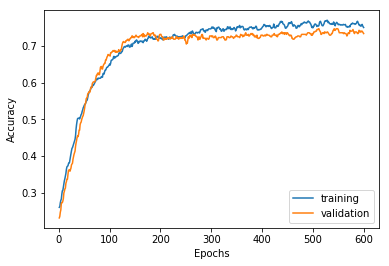

In [56]:
# 訓練セットと検証セットの学習サイクルを図で表す
#import matplotlib.pyplot as plt
#%matplotlib inline
acc = history_dict['acc']
val_acc = history_dict['val_acc']
epochs = range(1, len(acc) + 1)
#plt.plot(range(1, epochs+1), result.history['acc'], label="training")
#plt.plot(range(1, epochs+1), result.history['val_acc'], label="validation")
plt.plot(epochs, acc, label="training")
plt.plot(epochs, val_acc, label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

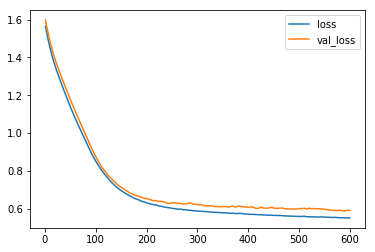

In [57]:
# 損失関数に対してのグラフ
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
#plt.ylim((0.2, 0.7))
plt.legend(loc='best')
plt.show() 

In [59]:
#多クラスの混合行列を作成
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)

In [60]:
pred

array([[2.2270360e-03, 1.1877749e-02, 5.9570479e-01, 3.6558533e-01,
        2.4605026e-02],
       [9.8987684e-06, 1.1612633e-05, 5.6407214e-03, 1.9961463e-01,
        7.9472315e-01],
       [2.7072988e-07, 1.4754943e-07, 1.6743597e-04, 5.0497510e-02,
        9.4933468e-01],
       ...,
       [4.0762071e-04, 7.0384485e-03, 4.5925874e-01, 5.2662283e-01,
        6.6723619e-03],
       [7.6357217e-08, 2.6260764e-08, 6.8762805e-05, 3.9953306e-02,
        9.5997787e-01],
       [9.0103247e-04, 7.1773916e-03, 3.4658414e-01, 6.2552196e-01,
        1.9815473e-02]], dtype=float32)

In [61]:
print(confusion_matrix(np.argmax(y_test, axis=1), pred))

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [58]:
#多クラスの混合行列を作成
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
#print(confusion_matrix(y_test, pred))


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [31]:
# score = model.evaluate(X_test, y_test, verbose = 0)
# model.evaluate()は、最終的評価（損失関数と精度）を出すため，X_test，y_testを入れるべきだと思う
# たぶんここでの、epoch数は、model.fit()で宣言したepoch数と同じになるのかな？
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6135104906504224
Test accuracy: 0.718223583734784


In [32]:
#多クラスの混合行列を作成
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
print(confusion_matrix(y_test, pred))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets